In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix 
tf.__version__

'1.13.1'

In [2]:
# Import tensorflow datatset for load MINIST data-set
import tensorflow_datasets as tfds
# Load MNIST data
mnist_train = tfds.load(name="mnist", split=tfds.Split.TRAIN)
mnist_test = tfds.load(name="mnist", split=tfds.Split.TEST)
mnist_train


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.


W0707 10:08:16.298053 140477806012224 deprecation.py:323] From /home/ubuntu/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/tensorflow/python/ops/control_flow_ops.py:423: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


<DatasetV1Adapter shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>

In [3]:
# Converse data-set to batch data-set size = 30 for loading Asynochoric processs
mnist_train = mnist_train.repeat().shuffle(1024).batch(30)
mnist_train

<DatasetV1Adapter shapes: {image: (?, 28, 28, 1), label: (?,)}, types: {image: tf.uint8, label: tf.int64}>

In [4]:
# Prefetch will enable the input pipeline to asynchronously fetch batches while our model is training.
mnist_train = mnist_train.prefetch(tf.data.experimental.AUTOTUNE)
mnist_train
# Now you could loop over batches of the dataset and train
# for batch in mnist_train:
#   ...

<DatasetV1Adapter shapes: {image: (?, 28, 28, 1), label: (?,)}, types: {image: tf.uint8, label: tf.int64}>

In [5]:
import os
import functools
import operator
import gzip
import struct
import array
import tempfile
try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve  # py2
try:
    from urllib.parse import urljoin
except ImportError:
    from urlparse import urljoin
import numpy


__version__ = '0.2.2'


# `datasets_url` and `temporary_dir` can be set by the user using:
# >>> mnist.datasets_url = 'http://my.mnist.url'
# >>> mnist.temporary_dir = lambda: '/tmp/mnist'
datasets_url = 'http://yann.lecun.com/exdb/mnist/'
temporary_dir = tempfile.gettempdir


class IdxDecodeError(ValueError):
    """Raised when an invalid idx file is parsed."""
    pass


def download_file(fname, target_dir=None, force=False):
    """Download fname from the datasets_url, and save it to target_dir,
    unless the file already exists, and force is False.
    Parameters
    ----------
    fname : str
        Name of the file to download
    target_dir : str
        Directory where to store the file
    force : bool
        Force downloading the file, if it already exists
    Returns
    -------
    fname : str
        Full path of the downloaded file
    """
    target_dir = target_dir or temporary_dir()
    target_fname = os.path.join(target_dir, fname)

    if force or not os.path.isfile(target_fname):
        url = urljoin(datasets_url, fname)
        urlretrieve(url, target_fname)

    return target_fname


def parse_idx(fd):
    """Parse an IDX file, and return it as a numpy array.
    Parameters
    ----------
    fd : file
        File descriptor of the IDX file to parse
    endian : str
        Byte order of the IDX file. See [1] for available options
    Returns
    -------
    data : numpy.ndarray
        Numpy array with the dimensions and the data in the IDX file
    1. https://docs.python.org/3/library/struct.html
        #byte-order-size-and-alignment
    """
    DATA_TYPES = {0x08: 'B',  # unsigned byte
                  0x09: 'b',  # signed byte
                  0x0b: 'h',  # short (2 bytes)
                  0x0c: 'i',  # int (4 bytes)
                  0x0d: 'f',  # float (4 bytes)
                  0x0e: 'd'}  # double (8 bytes)

    header = fd.read(4)
    if len(header) != 4:
        raise IdxDecodeError('Invalid IDX file, '
                             'file empty or does not contain a full header.')

    zeros, data_type, num_dimensions = struct.unpack('>HBB', header)

    if zeros != 0:
        raise IdxDecodeError('Invalid IDX file, '
                             'file must start with two zero bytes. '
                             'Found 0x%02x' % zeros)

    try:
        data_type = DATA_TYPES[data_type]
    except KeyError:
        raise IdxDecodeError('Unknown data type '
                             '0x%02x in IDX file' % data_type)

    dimension_sizes = struct.unpack('>' + 'I' * num_dimensions,
                                    fd.read(4 * num_dimensions))

    data = array.array(data_type, fd.read())
    data.byteswap()  # looks like array.array reads data as little endian

    expected_items = functools.reduce(operator.mul, dimension_sizes)
    if len(data) != expected_items:
        raise IdxDecodeError('IDX file has wrong number of items. '
                             'Expected: %d. Found: %d' % (expected_items,
                                                          len(data)))

    return numpy.array(data).reshape(dimension_sizes)


def download_and_parse_mnist_file(fname, target_dir=None, force=False):
    """Download the IDX file named fname from the URL specified in dataset_url
    and return it as a numpy array.
    Parameters
    ----------
    fname : str
        File name to download and parse
    target_dir : str
        Directory where to store the file
    force : bool
        Force downloading the file, if it already exists
    Returns
    -------
    data : numpy.ndarray
        Numpy array with the dimensions and the data in the IDX file
    """
    fname = download_file(fname, target_dir=target_dir, force=force)
    fopen = gzip.open if os.path.splitext(fname)[1] == '.gz' else open
    with fopen(fname, 'rb') as fd:
        return parse_idx(fd)


def train_images():
    """Return train images from Yann LeCun MNIST database as a numpy array.
    Download the file, if not already found in the temporary directory of
    the system.
    Returns
    -------
    train_images : numpy.ndarray
        Numpy array with the images in the train MNIST database. The first
        dimension indexes each sample, while the other two index rows and
        columns of the image
    """
    return download_and_parse_mnist_file('train-images-idx3-ubyte.gz')


def test_images():
    """Return test images from Yann LeCun MNIST database as a numpy array.
    Download the file, if not already found in the temporary directory of
    the system.
    Returns
    -------
    test_images : numpy.ndarray
        Numpy array with the images in the train MNIST database. The first
        dimension indexes each sample, while the other two index rows and
        columns of the image
    """
    return download_and_parse_mnist_file('t10k-images-idx3-ubyte.gz')


def train_labels():
    """Return train labels from Yann LeCun MNIST database as a numpy array.
    Download the file, if not already found in the temporary directory of
    the system.
    Returns
    -------
    train_labels : numpy.ndarray
        Numpy array with the labels 0 to 9 in the train MNIST database.
    """
    return download_and_parse_mnist_file('train-labels-idx1-ubyte.gz')


def test_labels():
    """Return test labels from Yann LeCun MNIST database as a numpy array.
    Download the file, if not already found in the temporary directory of
    the system.
    Returns
    -------
    test_labels : numpy.ndarray
        Numpy array with the labels 0 to 9 in the train MNIST database.
    """
    return download_and_parse_mnist_file('t10k-labels-idx1-ubyte.gz')

In [6]:
train_images = train_images()
train_labels = train_labels()
test_images = test_images()
test_labels = test_labels()

img_size_flat = 28 * 28
num_class = 10
img_shape = [28, 28]

Helper-support for plotting images

In [31]:
def plot_images(images, true_labels, predict_labels = None):
    assert len(images) == len(true_labels)

    #Creating figure with 3x3 sub-plots
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace = 0.3, wspace = 0.3)
    for i, ax in enumerate(axes.flat):
        #Plotting image
        ax.imshow(images[i].reshape(img_shape), cmap = "binary")
        
        #Create label below each image
        if predict_labels is None:
            label = "True: {0}".format(true_labels[i])
        else:
            label = "True: {0}. Predict: {1}".format(true_labels[i], predict_labels[i])
        
        ax.set_xlabel(label)
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

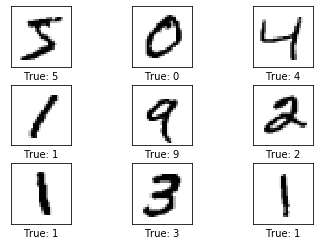

In [32]:
images = train_images[0:9]
true_labels = train_labels[0:9]
plot_images(images, true_labels)

In [9]:
x = tf.placeholder(tf.float32, [None, img_size_flat])
y_true = tf.placeholder(tf.float32, [None, num_class])
y_true_cls = tf.placeholder(tf.int64, [None])

In [10]:
weight = tf.Variable(tf.zeros([img_size_flat, num_class]))
bias = tf.Variable(tf.zeros([num_class]))

In [11]:
logits = tf.matmul(x, weight) + bias
y_predict = tf.nn.softmax(logits)
y_predict_cls = tf.argmax(y_predict, axis = 1)

In [12]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits,
                                                 labels = y_true)
cost = tf.reduce_mean(cross_entropy)

In [13]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.5).minimize(cost)

In [14]:
correct_pred = tf.equal(y_true_cls, y_predict_cls)

In [15]:
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [16]:
#create session
session = tf.Session()
#Initialize all variable
session.run(tf.global_variables_initializer())

In [17]:
#This function auto create batch file 
def random_batch_narray(narray, batch_size):
    batch_images = np.array([])
    return np.take(narray, np.random.choice(len(narray)))

In [18]:
def optimize(num_interator):
    for i in num_interator:
        BATCH_SIZE = 100
        #create batch file
        batch_img_train = random_batch_narray(train_images, BATCH_SIZE)
        batch_label_train = random_batch_narray(train_labels, BATCH_SIZE)
        #create .....
        feed_dict_train = {batch_img_train, batch_label_train}
        #run session
        session.run(optimizer, feed_dict = feed_dict_train)
    return

In [19]:
# Reshape test_images to [-1, 784]
test_images_2d = test_images.reshape(-1, 784)
feed_dict_test = {x: test_images_2d,
                  y_true_cls: test_labels}
print(test_images_2d.shape)
print(test_labels.shape)

(10000, 784)
(10000,)


In [20]:
def print_accuracy():
    #use tensorflow to calculate accurancy
    acc = session.run(accuracy, feed_dict=feed_dict_test)

    #print accurancy 
    print("Accuracy: {0:.1%}".format(acc))

In [21]:
def print_confusion_matrix():
    # Get true class
    cls_true = y_true
    # Get predict class
    cls_predict = session.run(y_pred_cls, feed_dict = feed_dict_test)
    # Get the confusion matrix using sk-learn
    cm = confusion_matrix(y_true = cls_true,
                          y_pred = cls_pred)
    # Print the confusion matrix as the text
    print(cm)
    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [22]:
def plot_example_errors():
    # Use Tensorflow to get a list of boolean values
    # whether each images is has been correctly,
    # and a list for predicted class of each test images.
    correct, cls_pred = session.run([correct_pred, y_predict_cls], 
                                     feed_dict = feed_dict_test)
    # Negative boolean array
    incorrect = (correct == False)
    
    # Get the images from test set have been predict incorrect 
    images_incorrect = test_images[incorrect]
    
    # Get the predict label of those images
    pred_incorrect = cls_pred[incorrect]
    
    # Get the true label of those images 
    true_label = test_labels[incorrect]
    plot_images(images_incorrect[0:9],
                true_label[0:9],
                pred_incorrect[0:9])

In [23]:
def plot_weight():
    weights = session.run(weights)
    
    # Get the min, max weight.
    # This using to correct the colour intensty accros 
    # images to compare with orther images.
    w_min = np.min(weights)
    w_max = mp.max(weights)
    
    # Create figure with 3x4 subplot,
    # where the 2 last sublot is unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace = 0.3, 
                        wspace = 0.3)
    
    for i, ax in enumerate(axes.plat):
        if i < 10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [24]:
print_accuracy()

Accuracy: 9.8%


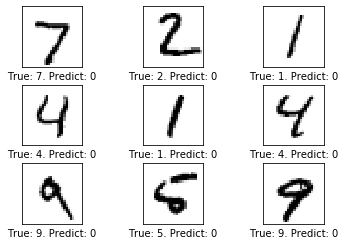

In [33]:
plot_example_errors()